<a href="https://colab.research.google.com/github/ianaroung/NeuralFCA_Gagarina/blob/main/NeuralFCA_Big_hw_Gagarina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
!pip install fcapy[all]
!pip install frozendict
!pip install ipynb
!pip install sparselinear
!pip install bitsets
!pip install bitarray
import torch
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cuda118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cuda118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cuda118.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cuda118.html
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cuda118.html
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cuda118.html
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-w0ogkmkx
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-w0ogkmkx
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 6544b1ed310b8d07438e96c009b13ca66ef2a654
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Import libs

In [87]:
import numpy as np
import pandas as pd

In [88]:
from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice

In [89]:
from fcapy.visualizer import LineVizNx
import matplotlib.pyplot as plt

plt.rcParams['figure.facecolor'] = (1,1,1,1)

In [90]:
!python neural_lib.py install

In [91]:
import neural_lib as nl

# Step 0. Binarize the data

Reading the datasets:

In [92]:
data1 = pd.read_csv('hcvdat0.csv')
data2 = pd.read_csv('heart_failure_clinical_records_dataset.csv')
data3 = pd.read_excel('Mesothelioma data set.xlsx')

Drop missing values and preprocess some features.

In [93]:
data1 = data1.iloc[:,1:]
data1 = data1.dropna()
data1 = pd.get_dummies(data1, columns = ['Sex'])
data1['Category'].replace(to_replace=['0=Blood Donor', '0s=suspect Blood Donor', '1=Hepatitis', '2=Fibrosis', '3=Cirrhosis'], value=[0, 0, 1, 2, 3], inplace = True)

data2 = data2.dropna()

data3 = data3.dropna()
#Заменим в target 2 на 1
data3.loc[data3['class of diagnosis'] == 2, 'class of diagnosis'] = 0

The first dataset, whose original target has 4 categories, one of which is healthy people (blood donors), and the other 3 categories are people with different stages of hepatitis C (initial stage, fibrosis and cirrhosis). Thus, we can replace it with 2 categories: people with hepatitis and healthy people.

In [94]:
data1.loc[data1['Category'] == 0, 'Category'] = 0
data1.loc[data1['Category'] != 0, 'Category'] = 1

The hepatitis C may be indicated by elevated levels of ALT, AST, bilirubin levels, GGT and sometimes creatinine. This information was found on the Internet but we can see it using the next code:

In [95]:
data1.groupby(['Category']).mean()

,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,Sex_f,Sex_m
Category,,,,,,,,,,,,,
0,47.311445,41.954409,68.677298,27.792683,27.102064,8.519137,8.374559,5.480619,78.930582,30.705629,71.857223,0.393996,0.606004
1,48.428571,38.482143,62.848214,14.989286,97.264286,34.803571,6.576786,4.541607,107.733929,109.514286,72.203571,0.285714,0.714286


So, for the df_bin1 we will use these features:

In [96]:
df_bin1 = data1[['ALT', 'AST', 'CREA', 'BIL', 'GGT', 'Category']]

In [97]:
df_bin1.loc[df_bin1['BIL'] >= 10, 'BIL'] = True
df_bin1.loc[df_bin1['BIL'] < 10, 'BIL'] = False
df_bin1.loc[df_bin1['ALT'] < 20, 'ALT'] = True
df_bin1.loc[df_bin1['ALT'] >= 20, 'ALT'] = False
df_bin1.loc[df_bin1['CREA'] < 100, 'CREA'] = True
df_bin1.loc[df_bin1['CREA'] >= 100, 'CREA'] = False
df_bin1.loc[df_bin1['AST'] < 50, 'AST'] = True
df_bin1.loc[df_bin1['AST'] >= 50, 'AST'] = False
df_bin1.loc[df_bin1['GGT'] >= 50, 'GGT'] = True
df_bin1.loc[df_bin1['GGT'] < 50, 'GGT'] = False
df_bin1 = df_bin1.replace({1: True, 0: False})
df_bin1

,ALT,AST,CREA,BIL,GGT,Category
0,True,True,False,False,False,False
1,True,True,True,False,False,False
2,False,False,True,False,False,False
3,False,True,True,False,False,False
4,False,True,True,False,False,False
...,...,...,...,...,...,...
608,True,False,True,False,False,True
609,True,False,False,False,False,True
610,True,False,True,False,False,True
611,True,True,True,False,False,True



For this dataset I leave two signs, since according to the study they are the most informative (https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5#Sec8). I also tried to add other features, but they were not important, the neurons mainly used these features, so I decided to split these features into more intervals and remove others so as not to unnecessarily complicate the model.

In [98]:
data2.groupby(['DEATH_EVENT']).mean()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
DEATH_EVENT,,,,,,,,,,,,
0,58.761906,0.408867,540.054187,0.418719,40.26601,0.325123,266657.489901,1.184877,137.216749,0.650246,0.325123,158.339901
1,65.215281,0.479167,670.197917,0.416667,33.46875,0.406250,256381.044792,1.835833,135.375000,0.645833,0.312500,70.885417


In [99]:
df_bin2 = data2[['serum_creatinine', 'ejection_fraction', 'DEATH_EVENT']]

In [100]:
df_bin2['ejection_fraction>20'] = df_bin2['ejection_fraction']
df_bin2.loc[df_bin2['ejection_fraction>20'] < 20, 'ejection_fraction>20'] = False
df_bin2.loc[df_bin2['ejection_fraction>20'] >= 20, 'ejection_fraction>20'] = True

df_bin2['ejection_fraction>30'] = df_bin2['ejection_fraction']
df_bin2.loc[df_bin2['ejection_fraction>30'] < 30, 'ejection_fraction>30'] = False
df_bin2.loc[df_bin2['ejection_fraction>30'] >= 30, 'ejection_fraction>30'] = True

df_bin2['ejection_fraction>38'] = df_bin2['ejection_fraction']
df_bin2.loc[df_bin2['ejection_fraction>38'] < 38, 'ejection_fraction>38'] = False
df_bin2.loc[df_bin2['ejection_fraction>38'] >= 38, 'ejection_fraction>38'] = True

df_bin2['ejection_fraction>45'] = df_bin2['ejection_fraction']
df_bin2.loc[df_bin2['ejection_fraction>45'] < 45, 'ejection_fraction>45'] = False
df_bin2.loc[df_bin2['ejection_fraction>45'] >= 45, 'ejection_fraction>45'] = True

df_bin2['ejection_fraction>50'] = df_bin2['ejection_fraction']
df_bin2.loc[df_bin2['ejection_fraction>50'] < 50, 'ejection_fraction>50'] = False
df_bin2.loc[df_bin2['ejection_fraction>50'] >= 50, 'ejection_fraction>50'] = True

df_bin2['ejection_fraction>55'] = df_bin2['ejection_fraction']
df_bin2.loc[df_bin2['ejection_fraction>55'] < 55, 'ejection_fraction>55'] = False
df_bin2.loc[df_bin2['ejection_fraction>55'] >= 55, 'ejection_fraction>55'] = True

df_bin2['ejection_fraction>60'] = df_bin2['ejection_fraction']
df_bin2.loc[df_bin2['ejection_fraction>60'] < 60, 'ejection_fraction>60'] = False
df_bin2.loc[df_bin2['ejection_fraction>60'] >= 60, 'ejection_fraction>60'] = True

df_bin2['ejection_fraction>70'] = df_bin2['ejection_fraction']
df_bin2.loc[df_bin2['ejection_fraction>70'] < 70, 'ejection_fraction>70'] = False
df_bin2.loc[df_bin2['ejection_fraction>70'] >= 70, 'ejection_fraction>70'] = True



df_bin2['serum_creatinine<0.9'] = df_bin2['serum_creatinine']
df_bin2.loc[df_bin2['serum_creatinine<0.9'] <= 0.9, 'serum_creatinine<0.9'] = True
df_bin2.loc[df_bin2['serum_creatinine<0.9'] > 0.9, 'serum_creatinine<0.9'] = False

df_bin2['serum_creatinine<1.1'] = df_bin2['serum_creatinine']
df_bin2.loc[df_bin2['serum_creatinine<1.1'] <= 1.1, 'serum_creatinine<1.1'] = True
df_bin2.loc[df_bin2['serum_creatinine<1.1'] > 1.1, 'serum_creatinine<1.1'] = False

df_bin2['serum_creatinine<1.25'] = df_bin2['serum_creatinine']
df_bin2.loc[df_bin2['serum_creatinine<1.25'] <= 1.25, 'serum_creatinine<1.25'] = True
df_bin2.loc[df_bin2['serum_creatinine<1.25'] > 1.25, 'serum_creatinine<1.25'] = False

df_bin2['serum_creatinine<1.4'] = df_bin2['serum_creatinine']
df_bin2.loc[df_bin2['serum_creatinine<1.4'] <= 1.4, 'serum_creatinine<1.4'] = True
df_bin2.loc[df_bin2['serum_creatinine<1.4'] > 1.4, 'serum_creatinine<1.4'] = False

df_bin2['serum_creatinine<1.6'] = df_bin2['serum_creatinine']
df_bin2.loc[df_bin2['serum_creatinine<1.6'] <= 1.6, 'serum_creatinine<1.6'] = True
df_bin2.loc[df_bin2['serum_creatinine<1.6'] > 1.6, 'serum_creatinine<1.6'] = False

df_bin2['serum_creatinine<2'] = df_bin2['serum_creatinine']
df_bin2.loc[df_bin2['serum_creatinine<2'] <= 2, 'serum_creatinine<2'] = True
df_bin2.loc[df_bin2['serum_creatinine<2'] > 2, 'serum_creatinine<2'] = False

df_bin2['serum_creatinine<5'] = df_bin2['serum_creatinine']
df_bin2.loc[df_bin2['serum_creatinine<5'] <= 5, 'serum_creatinine<5'] = True
df_bin2.loc[df_bin2['serum_creatinine<5'] > 5, 'serum_creatinine<5'] = False

df_bin2 = df_bin2.drop(['serum_creatinine'], axis=1)
df_bin2 = df_bin2.drop(['ejection_fraction'], axis=1)

df_bin2 = df_bin2.replace({1: True, 0: False})
df_bin2

<ipython-input-100-0d9eb5f06515>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bin2['ejection_fraction>20'] = df_bin2['ejection_fraction']
<ipython-input-100-0d9eb5f06515>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bin2['ejection_fraction>30'] = df_bin2['ejection_fraction']
<ipython-input-100-0d9eb5f06515>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

,DEATH_EVENT,ejection_fraction>20,ejection_fraction>30,ejection_fraction>38,ejection_fraction>45,ejection_fraction>50,ejection_fraction>55,ejection_fraction>60,ejection_fraction>70,serum_creatinine<0.9,serum_creatinine<1.1,serum_creatinine<1.25,serum_creatinine<1.4,serum_creatinine<1.6,serum_creatinine<2,serum_creatinine<5
0,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True
1,True,True,True,True,False,False,False,False,False,False,True,True,True,True,True,True
2,True,True,False,False,False,False,False,False,False,False,False,False,True,True,True,True
3,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True
4,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,False,True,True,True,False,False,False,False,False,False,True,True,True,True,True,True
295,False,True,True,True,False,False,False,False,False,False,False,True,True,True,True,True
296,False,True,True,True,True,True,True,True,False,False,True,True,True,True,True,True
297,False,True,True,True,False,False,False,False,False,False,False,False,True,True,True,True



There are quite a lot of features in the third dataset - 34, so you can just take all the binary ones, there are 13 of them.

In [101]:
df_bin3 = data3[['gender', 'asbestos exposure', 'diagnosis method', 'cytology', 'dyspnoea', 'ache on chest',
                'weakness', 'performance status', 'hemoglobin (HGB)', 'dead or not', 'pleural effusion', 'pleural thickness on tomography',
                'pleural level of acidity (pH)', 'class of diagnosis']]

In [102]:
df_bin3 = df_bin3.replace({1: True, 0: False})
df_bin3

,gender,asbestos exposure,diagnosis method,cytology,dyspnoea,ache on chest,weakness,performance status,hemoglobin (HGB),dead or not,pleural effusion,pleural thickness on tomography,pleural level of acidity (pH),class of diagnosis
0,True,True,True,True,True,True,False,True,True,True,False,False,False,True
1,True,True,True,False,True,True,True,False,False,True,True,True,True,True
2,True,True,False,False,False,False,False,True,True,True,False,False,False,False
3,True,True,True,False,False,True,True,True,True,True,True,False,False,True
4,True,True,True,True,True,True,False,True,False,True,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,True,True,True,False,True,True,False,False,False,True,True,True,False,True
320,True,True,True,False,True,True,False,False,False,True,True,True,False,True
321,True,True,True,False,True,True,False,False,False,True,True,False,True,True
322,True,False,False,False,True,False,False,True,True,True,True,True,False,False


Split the data to train and test

In [103]:
from sklearn.model_selection import train_test_split

In [104]:
s = np.arange(0, 700)
a = []
for i in range(len(s)):
  a.append(str(s[i]))

In [105]:
y1 = df_bin1['Category']
x1 = df_bin1.drop(['Category'], axis=1)

In [106]:
x1['id'] = a[:589]
x1 = x1.set_index('id')

In [107]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(x1, y1, test_size=0.4, random_state=42)

In [108]:
y2 = df_bin2['DEATH_EVENT']
x2 = df_bin2.drop(['DEATH_EVENT'], axis=1)

In [109]:
x2['id'] = a[:299]
x2 = x2.set_index('id')

In [110]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.4, random_state=42)

In [111]:
y3 = df_bin3['class of diagnosis']
x3 = df_bin3.drop(['class of diagnosis'], axis=1)

In [112]:
x3['id'] = a[:324]
x3 = x3.set_index('id')

In [113]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(x3, y3, test_size=0.4, random_state=42)

## Step 1. Build Monotone Concept Lattice

Put binarized data in FormalContext and compute monotone ConceptLattice

In [114]:
K_train1 = FormalContext.from_pandas(X_train1)
K_train1

FormalContext (353 objects, 5 attributes, 805 connections)
   |ALT|AST|CREA|BIL|GGT|
431|  X|  X|   X|   |   |
174|  X|  X|   X|   |   |
31 |   |  X|   X|   |   |
113|   |  X|   X|   |   |
23 |   |  X|   X|   |   |
173|   |  X|   X|   |   |
399|  X|  X|   X|   |   |
495|  X|  X|   X|   |   |
57 |   |  X|   X|   |   |
312|  X|  X|   X|   |   |
.........................
.........................
330|  X|  X|   X|   |   |
214|   |  X|   X|   |   |
466|  X|  X|   X|   |   |
121|   |  X|   X|   |   |
20 |   |  X|    |   |   |
71 |   |  X|   X|   |   |
106|   |  X|   X|   |   |
270|  X|  X|   X|   |   |
435|  X|  X|   X|   |   |
102|  X|  X|   X|   |   |

In [115]:
K_train2 = FormalContext.from_pandas(X_train2)
K_train2

FormalContext (179 objects, 15 attributes, 1408 connections)
   |ejection_fraction>20|ejection_fraction>30|ejection_fraction>38|ejection_fraction>45|ejection_fraction>50|...|serum_creatinine<1.25|serum_creatinine<1.4|serum_creatinine<1.6|serum_creatinine<2|serum_creatinine<5|
232|                   X|                   X|                    |                    |                    |...|                    X|                   X|                   X|                 X|                 X|
182|                   X|                    |                    |                    |                    |...|                    X|                   X|                   X|                 X|                 X|
180|                   X|                   X|                    |                    |                    |...|                    X|                   X|                   X|                 X|                 X|
137|                   X|                    |                    |        

In [116]:
K_train3 = FormalContext.from_pandas(X_train3)
K_train3

FormalContext (194 objects, 13 attributes, 1647 connections)
   |gender|asbestos exposure|diagnosis method|cytology|dyspnoea|...|hemoglobin (HGB)|dead or not|pleural effusion|pleural thickness on tomography|pleural level of acidity (pH)|
37 |      |                X|               X|        |       X|...|                |          X|               X|                              X|                             |
233|      |                X|                |       X|       X|...|               X|          X|               X|                              X|                            X|
67 |     X|                 |               X|        |       X|...|                |          X|               X|                               |                             |
271|     X|                X|                |        |       X|...|               X|          X|               X|                              X|                             |
139|     X|                X|               X|        

In [117]:
L1 = ConceptLattice.from_context(K_train1, is_monotone=True)
len(L1)

8

In [118]:
L2 = ConceptLattice.from_context(K_train2, is_monotone=True)
len(L2)

47

In [119]:
L3 = ConceptLattice.from_context(K_train3, is_monotone=True)
len(L3)

543

Compute F1 score for each formal concept  (assuming that an object is predicted True if it is in the extent of the concept)

In [120]:
from sklearn.metrics import f1_score

for c1 in L1:
    y_preds1 = np.zeros(K_train1.n_objects)
    y_preds1[list(c1.extent_i)] = 1
    c1.measures['f1_score'] = f1_score(y_train1, y_preds1)

In [121]:
from sklearn.metrics import f1_score

for c2 in L2:
    y_preds2 = np.zeros(K_train2.n_objects)
    y_preds2[list(c2.extent_i)] = 1
    c2.measures['f1_score'] = f1_score(y_train2, y_preds2)

In [122]:
from sklearn.metrics import f1_score

for c3 in L3:
    y_preds3 = np.zeros(K_train3.n_objects)
    y_preds3[list(c3.extent_i)] = 1
    c3.measures['f1_score'] = f1_score(y_train3, y_preds3)

Select indices of the best concepts from the lattice

In [123]:
best_concepts1 = list(L1.measures['f1_score'].argsort()[::-1][3:4])

# assert len({g_i for c in L1[best_concepts1] for g_i in c.extent_i})==K_train1.n_objects, "Selected concepts do not cover all train objects"

In [124]:
best_concepts2 = list(L2.measures['f1_score'].argsort()[::-1][:2])

#assert len({g_i for c in L2[best_concepts2] for g_i in c.extent_i})==K_train2.n_objects, "Selected concepts do not cover all train objects"

In [125]:
best_concepts3 = list(L3.measures['f1_score'].argsort()[::-1][:4])

# assert len({g_i for c in L3[best_concepts3] for g_i in c.extent_i})==K_train3.n_objects, "Selected concepts do not cover all train objects"

Construct neural network based on concept lattice

In [126]:
cn1 = nl.ConceptNetwork.from_lattice(L1, best_concepts1, sorted(set(y_train1)))

In [127]:
cn2 = nl.ConceptNetwork.from_lattice(L2, best_concepts2, sorted(set(y_train2)))

In [128]:
cn3 = nl.ConceptNetwork.from_lattice(L3, best_concepts3, sorted(set(y_train3)))

Setup visuzalier for the architecture

In [129]:
vis1 = LineVizNx(node_label_font_size=14, node_label_func=lambda el_i, P: nl.zneuron_label_func(el_i, P, set(cn1.attributes))+'\n\n')

In [130]:
vis2 = LineVizNx(node_label_font_size=14, node_label_func=lambda el_i, P: nl.zneuron_label_func(el_i, P, set(cn2.attributes))+'\n\n')

In [131]:
vis3 = LineVizNx(node_label_font_size=14, node_label_func=lambda el_i, P: nl.zneuron_label_func(el_i, P, set(cn3.attributes))+'\n\n')

In [132]:
descr1 = {'BIL', 'ALT'}

traced1 = cn1.trace_description(descr1, include_targets=False)

In [133]:
descr2 = {'serum_creatinine<1.4', 'ejection_fraction>30'}

traced2 = cn2.trace_description(descr2, include_targets=False)

In [134]:
descr3 = {'dead or not'}

traced3 = cn3.trace_description(descr3, include_targets=False)

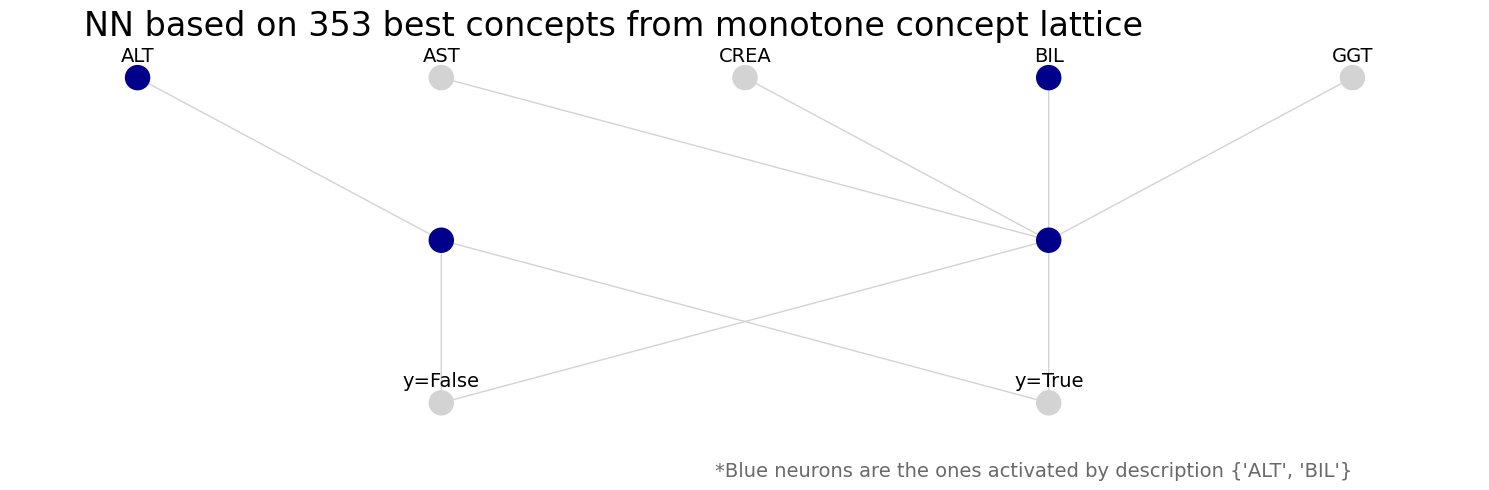

In [135]:
fig, ax = plt.subplots(figsize=(15,5))

vis1.draw_poset(
    cn1.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn1.attributes), only_new_attrs=True)+'\n\n',
    node_color=['darkblue' if el_i in traced1 else 'lightgray' for el_i in range(len(cn1.poset))]
)
plt.title(f'NN based on 353 best concepts from monotone concept lattice', loc='left', x=0.05, size=24)

plt.text(max(vis1.mover.posx), min(vis1.mover.posy)-0.3, f'*Blue neurons are the ones activated by description {descr1}', fontsize=14, ha='right', color='dimgray')

plt.subplots_adjust()
plt.tight_layout()
plt.show()

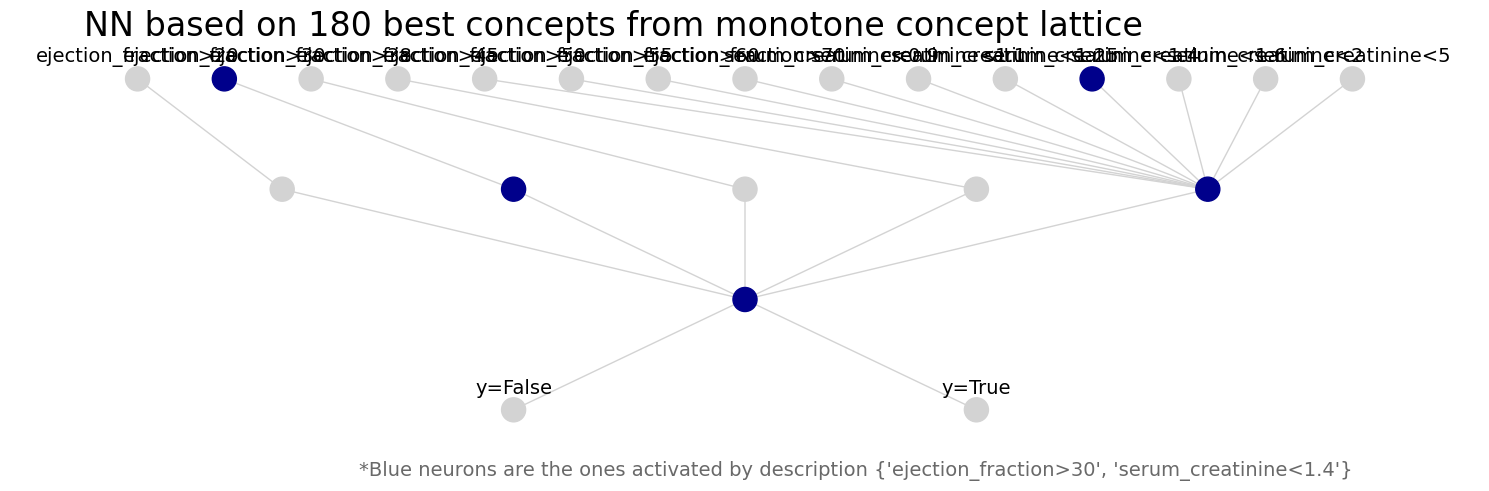

In [136]:
fig, ax = plt.subplots(figsize=(15,5))

vis2.draw_poset(
    cn2.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn2.attributes), only_new_attrs=True)+'\n\n',
    node_color=['darkblue' if el_i in traced2 else 'lightgray' for el_i in range(len(cn2.poset))]
)
plt.title(f'NN based on 180 best concepts from monotone concept lattice', loc='left', x=0.05, size=24)

plt.text(max(vis2.mover.posx), min(vis2.mover.posy)-0.3, f'*Blue neurons are the ones activated by description {descr2}', fontsize=14, ha='right', color='dimgray')

plt.subplots_adjust()
plt.tight_layout()
plt.show()

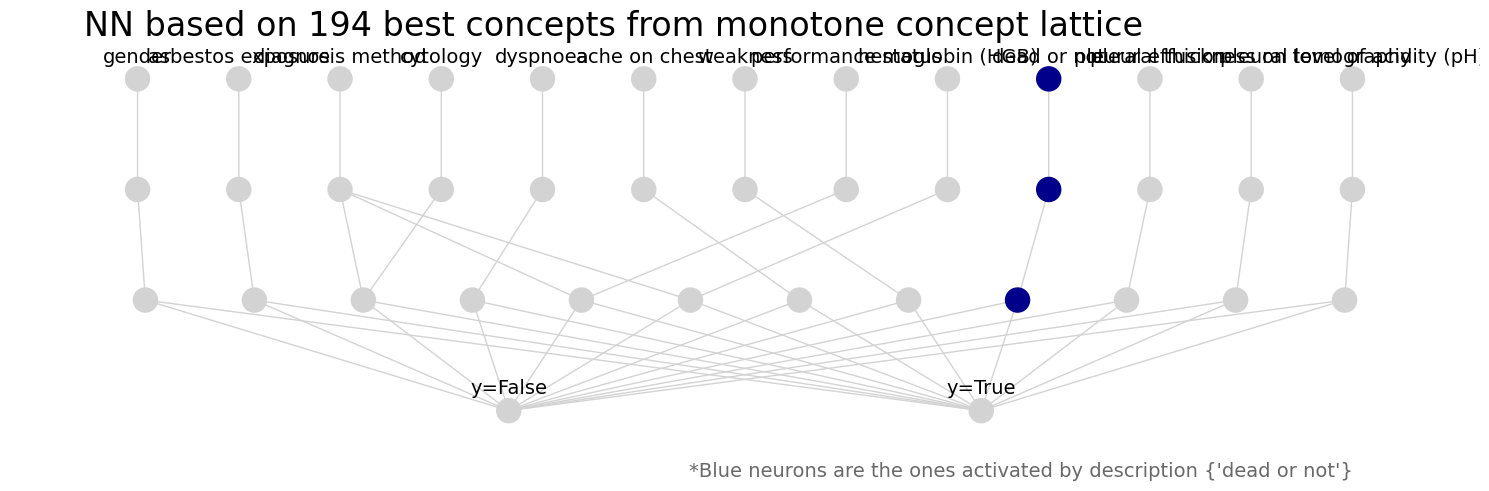

In [137]:
fig, ax = plt.subplots(figsize=(15,5))

vis3.draw_poset(
    cn3.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn3.attributes), only_new_attrs=True)+'\n\n',
    node_color=['darkblue' if el_i in traced3 else 'lightgray' for el_i in range(len(cn3.poset))]
)
plt.title(f'NN based on 194 best concepts from monotone concept lattice', loc='left', x=0.05, size=24)

plt.text(max(vis3.mover.posx), min(vis3.mover.posy)-0.3, f'*Blue neurons are the ones activated by description {descr3}', fontsize=14, ha='right', color='dimgray')

plt.subplots_adjust()
plt.tight_layout()
plt.show()

Now fit the network

In [138]:
cn1.fit(X_train1, y_train1)

In [139]:
cn2.fit(X_train2, y_train2)

In [140]:
cn3.fit(X_train3, y_train3)

To obtain the prediction

In [141]:
print('Class prediction', cn1.predict(X_test1).numpy())
print('Class prediction with probabilities', cn1.predict_proba(X_test1).detach().numpy())
print('True class', y_test1.values)

Class prediction [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Class prediction with probabilities [[0.9845286  0.01547142]
 [0.9845286  0.01547142]
 [0.99774337 0.00225671]
 [0.99774337 0.00225671]
 [0.9845286  0.01547142]
 [0.9845286  0.01547142]
 [0.9845286  0.01547142]
 [0.9845286  0.01547142]
 [0.99774337 0.00225671]
 [0.9845286  0.01547142]
 [0.94251186 0.05748814]
 [0.99774337 0.00225671]
 [0.99774337 0.00225671]
 [0.98453194 0.01546808]
 [0.9845286  0.01547142]
 [0.98453194 0.01546808]
 [0.99774337 0.00225671]
 [0.9969121  0.00308783]
 [0.9845286  0.01

In [142]:
(cn1.predict(X_test1).numpy() == y_test1).sum()/len(y_test1)

0.8940677966101694

In [143]:
f1_score(y_test1, cn1.predict(X_test1).numpy())

0.0

In [144]:
print('Class prediction', cn2.predict(X_test2).numpy())
print('Class prediction with probabilities', cn2.predict_proba(X_test2).detach().numpy())
print('True class', y_test2.values)

Class prediction [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]
Class prediction with probabilities [[0.90832466 0.09167531]
 [0.90832466 0.09167531]
 [0.90832466 0.09167531]
 [0.90832466 0.09167531]
 [0.90832466 0.09167531]
 [0.90832466 0.09167531]
 [0.90832466 0.09167531]
 [0.90832466 0.09167531]
 [0.90832466 0.09167531]
 [0.90832466 0.09167531]
 [0.90832466 0.09167531]
 [0.90832466 0.09167531]
 [0.90832466 0.09167531]
 [0.90832466 0.09167531]
 [0.90832466 0.09167531]
 [0.90832466 0.09167531]
 [0.90832466 0.09167531]
 [0.90832466 0.09167531]
 [0.90832466 0.09167531]
 [0.90832466 0.09167531]
 [0.90832466 0.09167531]
 [0.90832466 0.09167531]
 [0.90832466 0.09167531]
 [0.90832466 0.09167531]
 [0.90832466 0.09167531]
 [0.90832466 0.09167531]
 [0.90832466 0.09167531]
 [0.90832466 0.09167531]
 [

In [145]:
f1_score(y_test2, cn2.predict(X_test2).numpy())

0.0

In [146]:
(cn2.predict(X_test2).numpy() == y_test2).sum()/len(y_test2)

0.5833333333333334

In [147]:
print('Class prediction', cn3.predict(X_test3).numpy())
print('Class prediction with probabilities', cn3.predict_proba(X_test3).detach().numpy())
print('True class', y_test3.values)

Class prediction [0 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0
 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 0
 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 0 0
 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0]
Class prediction with probabilities [[0.9878257  0.01217424]
 [0.0020322  0.9979678 ]
 [0.0020322  0.9979678 ]
 [0.0020322  0.9979678 ]
 [0.9878257  0.01217424]
 [0.9878257  0.01217424]
 [0.0020322  0.9979678 ]
 [0.0020322  0.9979678 ]
 [0.0020322  0.9979678 ]
 [0.0020322  0.9979678 ]
 [0.9878257  0.01217424]
 [0.0020322  0.9979678 ]
 [0.9878257  0.01217424]
 [0.0020322  0.9979678 ]
 [0.0020322  0.9979678 ]
 [0.9878257  0.01217424]
 [0.0020322  0.9979678 ]
 [0.9878257  0.01217424]
 [0.0020322  0.9979678 ]
 [0.9878257  0.01217424]
 [0.0020322  0.9979678 ]
 [0.0020322  0.9979678 ]
 [0.0020322  0.9979678 ]
 [0.0020322  0.9979678 ]
 [0.0020322  0.9979678 ]
 [0.9878257  0.01217424]
 [0.0020322  0.9979678 ]
 [0.002

In [148]:
f1_score(y_test3, cn3.predict(X_test3).numpy())

1.0

In [149]:
(cn3.predict(X_test3).numpy() == y_test3).sum()/len(y_test3)

1.0

We see that the model predicts perfect the third dataset.

Let us look at the fitted weights of edges

In [150]:
edge_weights1 = cn1.edge_weights_from_network()

In [151]:
edge_weights2 = cn2.edge_weights_from_network()

In [152]:
edge_weights3 = cn3.edge_weights_from_network()

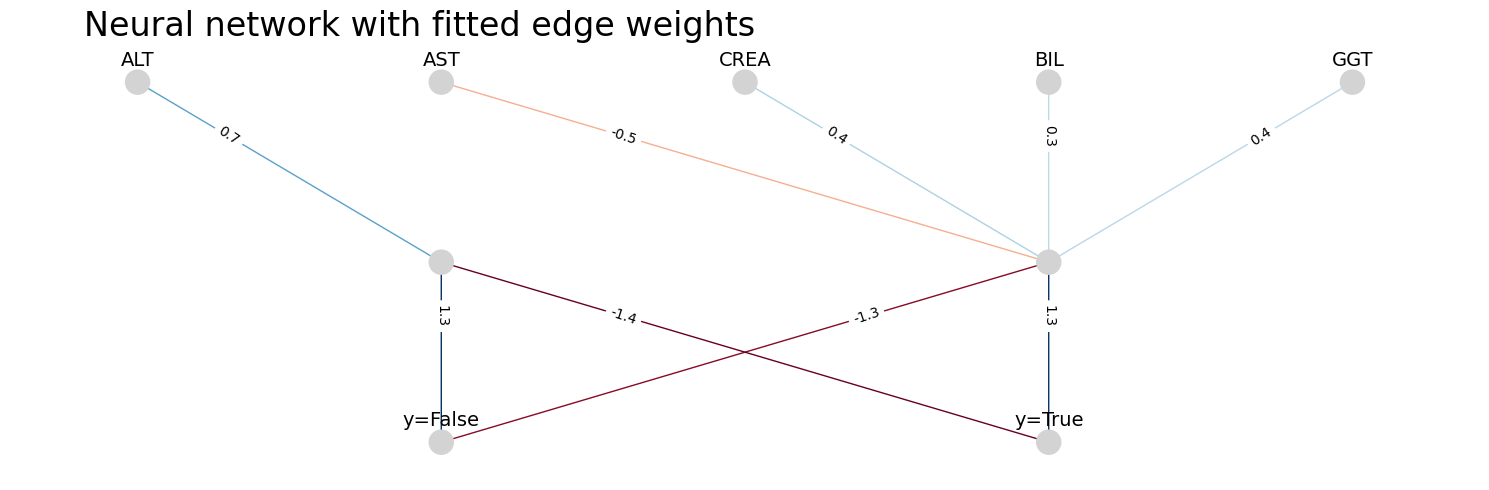

In [153]:
import networkx as nx

fig, ax = plt.subplots(figsize=(15,5))

vis1.draw_poset(
    cn1.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn1.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights1[edge] for edge in cn1.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn1.poset.to_networkx(), vis1.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights1.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, x=0.05, loc='left')
plt.tight_layout()
plt.subplots_adjust()
plt.savefig('fitted_network.png')
plt.show()

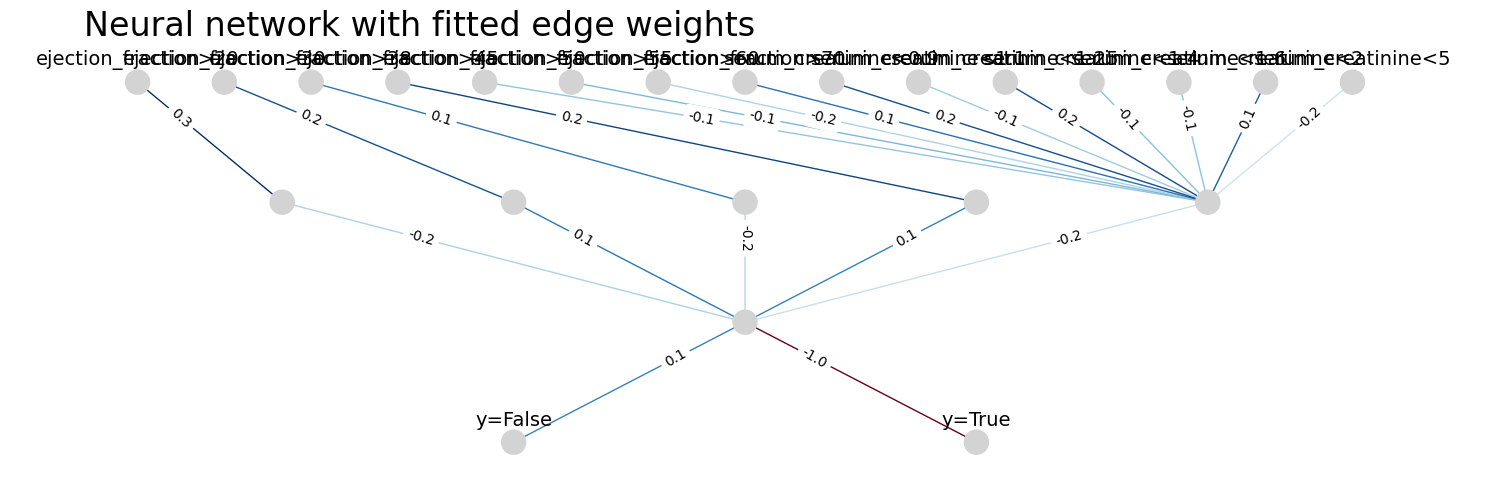

In [154]:
import networkx as nx

fig, ax = plt.subplots(figsize=(15,5))

vis2.draw_poset(
    cn2.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn2.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights2[edge] for edge in cn2.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn2.poset.to_networkx(), vis2.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights2.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, x=0.05, loc='left')
plt.tight_layout()
plt.subplots_adjust()
plt.savefig('fitted_network.png')
plt.show()

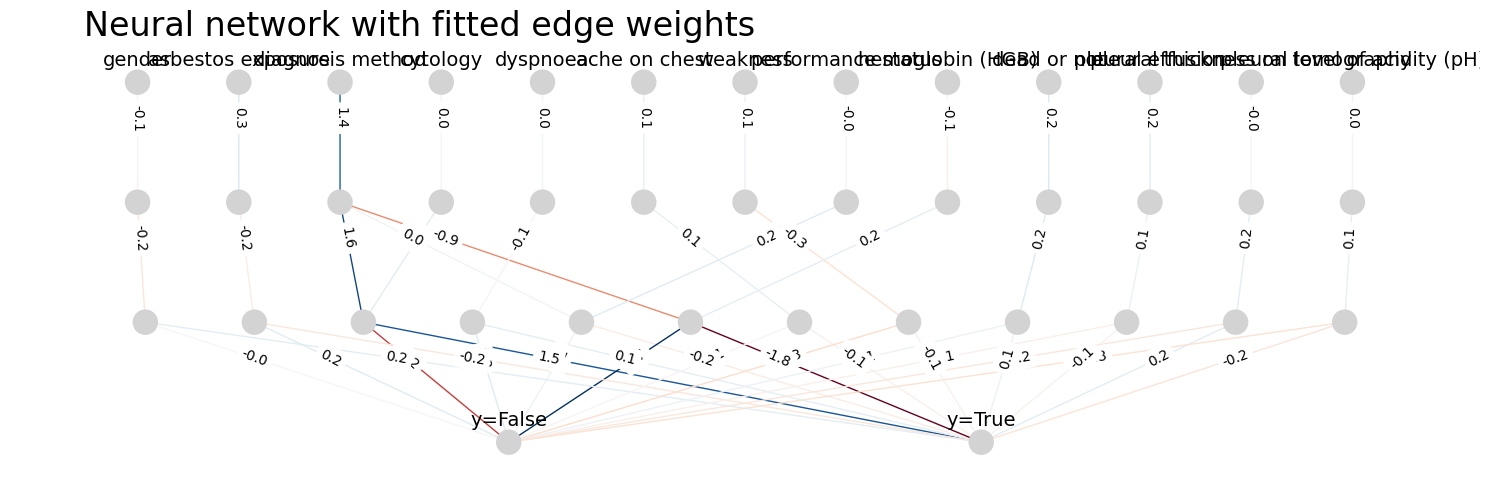

In [155]:
import networkx as nx

fig, ax = plt.subplots(figsize=(15,5))

vis3.draw_poset(
    cn3.poset, ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn3.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights3[edge] for edge in cn3.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn3.poset.to_networkx(), vis3.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights3.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, x=0.05, loc='left')
plt.tight_layout()
plt.subplots_adjust()
plt.savefig('fitted_network.png')
plt.show()

It is a good model but because of a lot of attributes the graph does not look pretty.